### Hyper MNIST

#### Loading MNIST

In [17]:
import os
import torchvision
import torchvision.transforms as transforms
## load mnist dataset

root = 'data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


In [18]:
train_set[0][0].size()

torch.Size([1, 28, 28])

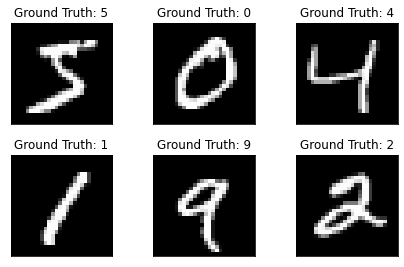

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [80]:
import torch

class TorchMNISTConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [81]:
torch_target_network = TorchMNISTConvNet()
pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
pytorch_total_params

77066

In [83]:
torch_target_network(torch.zeros(1,1,28,28)).size()

torch.Size([1, 10])

## Torch

In [7]:
from hypernn.torch.hypernet import TorchHyperNetwork
from hypernn.torch.weight_generator import TorchWeightGenerator
from hypernn.torch.embedding_module import TorchEmbeddingModule
from typing import Any, Optional

### Simple Embedding Module + Weight Generator

In [8]:
class StaticEmbeddingModule(TorchEmbeddingModule):
    def __init__(self, embedding_dim: int, num_embeddings: int, target_input_shape: Optional[Any] = None):
        super().__init__(embedding_dim, num_embeddings)
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, inp: Optional[Any] = None):
        indices = torch.arange(self.num_embeddings).to(self.device)
        return self.embedding(indices), {}


class StaticWeightGenerator(TorchWeightGenerator):
    def __init__(self, embedding_dim: int, num_embeddings: int, hidden_dim: int, target_input_shape: Optional[Any] = None):
        super().__init__(embedding_dim, num_embeddings, hidden_dim, target_input_shape)
        self.embedding_network = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, hidden_dim, bias=False),
        )

    def forward(self, embedding: torch.Tensor, inp: Optional[Any] = None) -> torch.Tensor:
        return self.embedding_network(embedding).view(-1), {}


### Instantiating hypernetwork with Class definitions

In [9]:
hypernetwork = TorchHyperNetwork.from_target(
    torch_target_network,
    embedding_module=StaticEmbeddingModule,
    weight_generator=StaticWeightGenerator,
    embedding_dim=4,
    num_embeddings=1024
)

In [ ]:
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

6692

In [11]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [34]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

#### Train hypernetwork

In [14]:
import tqdm
import numpy as np

optimizer = torch.optim.Adam(hypernetwork.parameters(), lr=0.0002)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Loss: 0.1299333516632517, Test Acc: 0.9627000093460083:   3%|▎         | 29/1000 [05:47<3:13:59, 11.99s/it] 


KeyboardInterrupt: 

#### Display subset of predictions

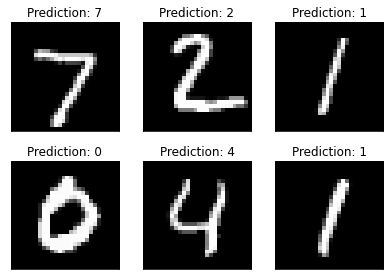

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Jax

In [20]:
# uncomment this to enable jax gpu preallocation, might lead to memory issues

import os
import jax
import jax.numpy as jnp

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [21]:
import flax.linen as linen

In [107]:
class JaxMNISTConvNet(linen.Module):

    @linen.compact
    def __call__(self, x):
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(10, kernel_size=(2,2), strides=2, padding="VALID")(x)
        x = x.reshape(x.shape[0], -1)
        x = linen.log_softmax(x)
        return x

In [108]:
jax_target_network = JaxMNISTConvNet()

In [109]:
from hypernn.jax.utils import count_jax_params

count_jax_params(jax_target_network, inputs=[jnp.zeros((64,64,1))])

77066

#### Simple Jax Hypernetwork

In [110]:
from typing import Optional, Any, Dict

from hypernn.jax.embedding_module import FlaxEmbeddingModule
from hypernn.jax.weight_generator import FlaxWeightGenerator
from hypernn.jax.hypernet import FlaxHyperNetwork


class CustomFlaxEmbeddingModule(FlaxEmbeddingModule):
    def setup(self):
        self.embedding = linen.Embed(self.num_embeddings, self.embedding_dim)

    def __call__(self, inp: Optional[Any] = None):
        indices = jnp.arange(0, self.num_embeddings)
        return self.embedding(indices), {}

class CustomFlaxWeightGenerator(FlaxWeightGenerator):
    def setup(self):
        self.dense1 = linen.Dense(32)
        self.dense2 = linen.Dense(self.hidden_dim, use_bias=False)

    def __call__(self, embedding, inp: Optional[Any] = None):
        x = self.dense1(embedding)
        x = linen.tanh(x)
        x = self.dense2(x)
        return x.reshape(-1), {}


### Making hypernetwork with `embedding_dim = 4` and `num_embeddings = 1024`

In [111]:
jax_hyper = FlaxHyperNetwork.from_target(
    target_network=jax_target_network,
    inputs=[jnp.zeros((28,28,1))],
    embedding_module=CustomFlaxEmbeddingModule,
    weight_generator=CustomFlaxWeightGenerator,
    embedding_dim = 4,
    num_embeddings = 1024
)

In [112]:
count_jax_params(jax_hyper, inputs=[[jnp.zeros((28,28,1))]])

6692

### Training MNIST

#### Creating train state

In [113]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_hyper_train_state(rng, model, learning_rate):
    """Creates initial `TrainState`."""
    params = model.init(rng, [jnp.zeros((28,28,1))])['params']
    tx = optax.chain(
        optax.adam(learning_rate)
    )
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

#### Update step

In [114]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [115]:
import functools

@jax.jit
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@functools.partial(jax.jit, static_argnames=('apply_fn'))
def train_step(apply_fn, state, x, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = apply_fn({'params': params}, inp=[x], has_aux=False)
        loss = cross_entropy_loss(logits=logits, labels=targets)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=targets)
    return state, metrics

In [116]:
import tqdm
import numpy as np
from einops import rearrange

bar = tqdm.tqdm(np.arange(1000))

rng = jax.random.PRNGKey(0)
state = create_hyper_train_state(rng, jax_hyper, 0.0002)

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        target = jnp.array(target.numpy())

        state, metrics = train_step(jax_hyper.apply, state, x, target)
        loss = metrics["loss"]
        # optimizer.zero_grad()
        # out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        # loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        # loss.backward()
        # optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        count += x.shape[0]
        logits = jax_hyper.apply({"params":state.params}, inp=[x], has_aux=False)
        # with torch.no_grad():
        #     out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        #     _, predicted = torch.max(out.detach(), -1)
        num_correct += jnp.sum(jnp.argmax(logits, -1) == target.numpy())
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Loss: 0.022955093814944122, Test Acc: 0.975100040435791:  28%|██▊       | 280/1000 [3:35:00<9:12:52, 46.07s/it]  


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()